### 进入 hr_viton 环境.1
> 切换Conda环境到 hr_viton


## 安装OpenPose

In [3]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  # https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/installation/0_index.md#windows-portable-demo
  !git submodule update --init --recursive --remote
  !sed -i 's/option(USE_CUDNN "Build OpenPose with cuDNN library support." ON)/option(USE_CUDNN "Build OpenPose with cuDNN library support." OFF)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  #编译安装
  # https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/installation/1_prerequisites.md
  # !apt-get install cmake-qt-gui
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
else 
 print("Avoid incorrect installation!")


True


## 获取模型

In [4]:
! cd openpose/models && ./openpose/models/getModels.sh

--2023-06-28 06:36:32--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/body_25/pose_iter_584000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.220.57
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.220.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104715850 (100M) [text/plain]
Saving to: ‘pose/body_25/pose_iter_584000.caffemodel’

pose_iter_584000.ca 100%[===================>]  99.86M  86.0MB/s    in 1.2s    

2023-06-28 06:36:33 (86.0 MB/s) - ‘pose/body_25/pose_iter_584000.caffemodel’ saved [104715850/104715850]

--2023-06-28 06:36:33--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.220.57
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.220.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
L

### 准备测试数据

In [8]:
# for storing input image
!mkdir ./openpose/image_path
# copy official provided data to image_path, you may need to download and unzip it in advance
# !cp ./test/image/000* ./image_path/
!cp ../data/test/image/000* ./openpose/image_path/
# create directories for generated results of OpenPose
!mkdir ./openpose/output
!mkdir ./openpose/output/json_path
!mkdir ./openpose/output
!mkdir ./openpose/output/img_path

mkdir: cannot create directory ‘./openpose/image_path’: File exists
mkdir: cannot create directory ‘./openpose/output’: File exists


In [11]:

# ! cd ./openpose/build/ && make -j`nproc`
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`


-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threa

In [9]:
!pwd
worker_dir = "/data/aigc/HR-VITON/package"
openpose_dir = "/data/aigc/HR-VITON/package/openpose"

/data/aigc/HR-VITON/package


### 生成OpenPose

In [1]:
### test/openpose_img test/openpose_json
# script = f'{worker_dir}/'
! cd openpose && ./build/examples/openpose/openpose.bin --image_dir ./image_path --hand --disable_blending --display 0 --write_json ./image_path/json_path/ --write_images ./image_path/img_path/ --num_gpu 1 --num_gpu_start 0


Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
E0731 05:58:43.650287 82142 common.cpp:121] Cannot create Curand generator. Curand won't be available.
OpenPose demo successfully finished. Total time: 4.235249 seconds.


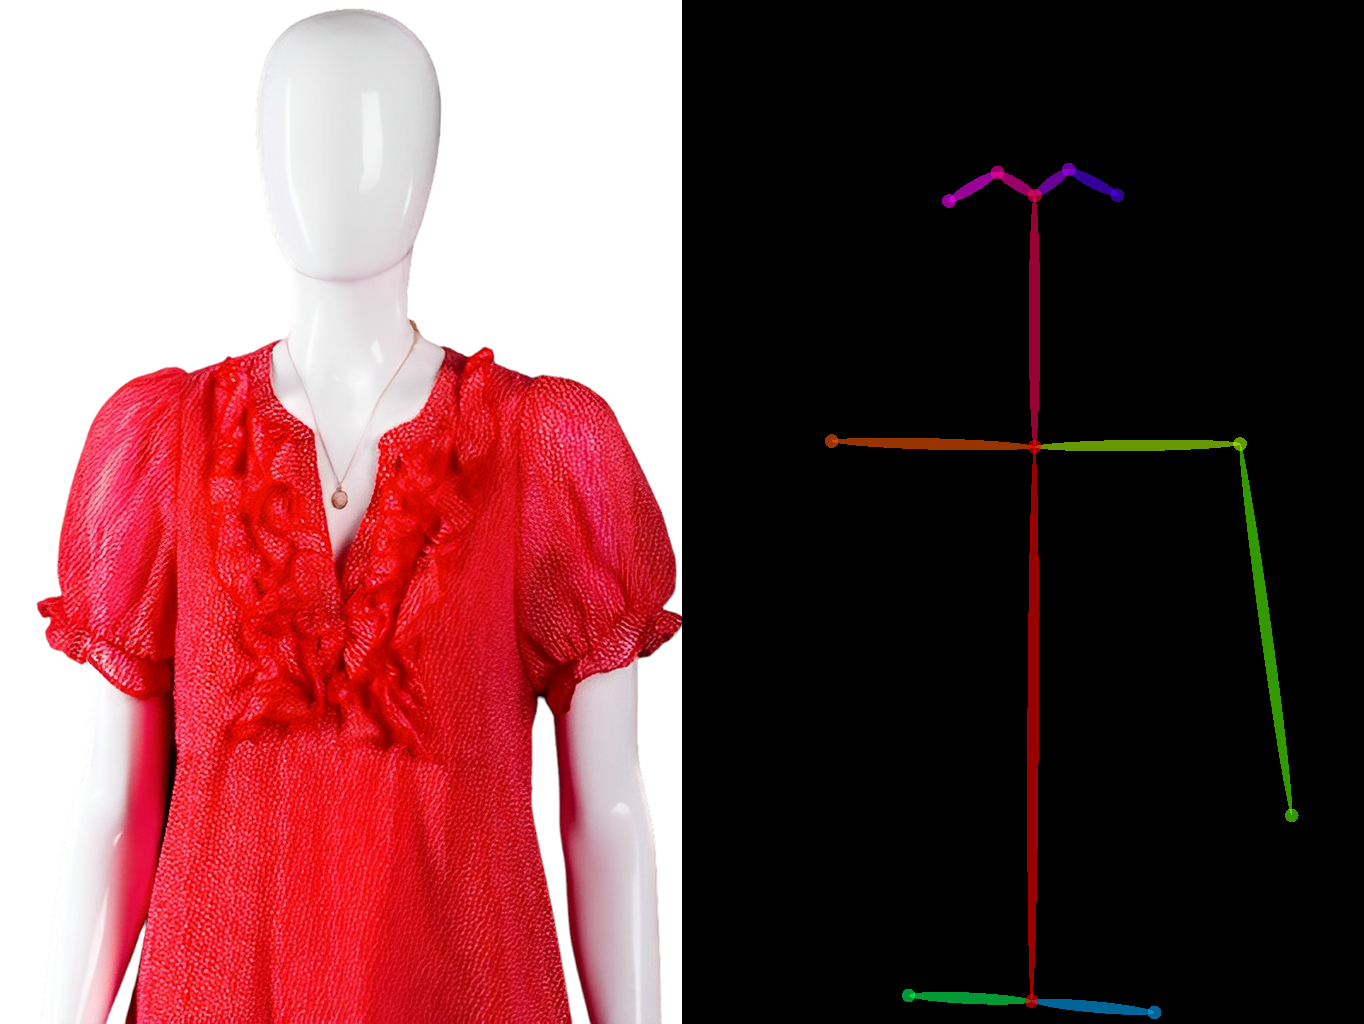

In [2]:
from PIL import Image
import cv2
import os
import numpy as np
input_images = [os.path.join(f"./openpose/image_path", x) for x in os.listdir(f"./openpose/image_path")]

output_images = [os.path.join(f"./openpose/image_path/img_path/", x) for x in os.listdir(f"./openpose/image_path/img_path/")]
sample_images = input_images[:1]
for idx, image_path in enumerate(sample_images):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if idx == 0:
        res = image
    else:
        res = np.concatenate([res, image], axis=1)

gif_str = image_path.strip(".jpg")
gif_str = gif_str.strip("./openpose/output/img_path")
json_str = f'./image_path/json_path/{gif_str}_keypoints.json'
# print(json_str)

sample_images = output_images[:1]
for idx, image_path in enumerate(sample_images):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    res = np.concatenate([res, image], axis=1)

res = Image.fromarray(res)
res

# ./output/json_path


In [62]:
with open(json_str, 'r') as f:
    ret = f.read()
    print(ret)

{"version":1.3,"people":[{"person_id":[-1],"pose_keypoints_2d":[371.684,167.704,0.933216,374.624,332.15,0.801548,255.479,306.573,0.706158,170.561,578.504,0.783719,201.665,856.322,0.707795,504.817,368.8,0.751704,487.844,547.42,0.385496,493.633,652.287,0.0951389,371.679,754.28,0.423855,281.026,757.128,0.384075,0,0,0,0,0,0,462.298,754.277,0.391744,0,0,0,0,0,0,329.366,144.999,0.94253,397.153,125.323,0.885736,303.747,170.585,0.880493,445.421,144.999,0.785291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"face_keypoints_2d":[],"hand_left_keypoints_2d":[477.114,665.83,0.0194634,467.241,671.096,0.0291542,485.012,696.766,0.0380818,499.493,693.475,0.0246651,498.177,701.374,0.0178496,495.544,689.526,0.0616293,510.683,715.196,0.0268086,519.24,717.829,0.0137556,491.595,703.348,0.0105217,498.835,689.526,0.0507948,515.948,709.931,0.0264938,518.581,708.614,0.0116793,535.037,709.931,0.0080397,502.126,693.475,0.0460288,513.974,708.614,0.0262562,514.632,708.614,0.0149074,535.037,711.905,0.0108726,498.177,700.057,

### 进入cihp_pgn 环境.2

> 切换Conda环境到 cihp_pgn_3.7

### 人体语义分割
> https://github.com/Engineering-Course/CIHP_PGN
> https://github.com/Engineering-Course/CIHP_PGN/issues/19

#### 准备测试数据

In [77]:
!git clone https://github.com/Engineering-Course/CIHP_PGN

!pwd
!ls -la

/data/aigc/HR-VITON/package
total 1239072
drwxr-xr-x  6 root root        162 Jun 28 11:14 .
drwxr-xr-x 12 root root       4096 Jun 28 10:58 ..
drwxr-xr-x  2 root root         39 Jun 28 06:30 .ipynb_checkpoints
drwxr-xr-x  8 root root       4096 Jun 28 11:09 CIHP_PGN
drwxrwxr-x  2 root root        130 Aug  1  2018 CIHP_pgn
-rw-r--r--  1 root root 1229940114 Jun 28 10:55 CIHP_pgn.zip
-rw-r--r--  1 root root     459947 Jun 28 11:14 Untitled.ipynb
-rw-r--r--  1 root root   38391207 Nov 20  2018 cmake-3.13.0-Linux-x86_64.tar.gz
drwxr-xr-x 17 root root       4096 Jun 28 08:25 openpose


In [74]:
## 下载模型

MODEL_PATHS = {
    "CIHP_pgn": {"id": "1Mqpse5Gen4V4403wFEpv3w3JAsWw2uhk", "name": "CIHP_pgn.zip"},
}

import os
repo_name='/data/aigc/HR-VITON/package'

os.chdir(repo_name)

def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), f'{repo_name}',"pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

for experiment_type in MODEL_PATHS:
    path = MODEL_PATHS[experiment_type]
    download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])
    !{download_command}

--2023-06-28 10:55:48--  https://docs.google.com/uc?export=download&confirm=t&id=1Mqpse5Gen4V4403wFEpv3w3JAsWw2uhk
Resolving docs.google.com (docs.google.com)... 142.251.16.113, 142.251.16.102, 142.251.16.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-3k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bnjg919pssim2a3n5hoa2u46l8ilck8m/1687949700000/03850692139160921763/*/1Mqpse5Gen4V4403wFEpv3w3JAsWw2uhk?e=download&uuid=87184b2c-75ef-4f3b-9f11-2b6aa74c6d77 [following]
--2023-06-28 10:55:48--  https://doc-00-3k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bnjg919pssim2a3n5hoa2u46l8ilck8m/1687949700000/03850692139160921763/*/1Mqpse5Gen4V4403wFEpv3w3JAsWw2uhk?e=download&uuid=87184b2c-75ef-4f3b-9f11-2b6aa74c6d77
Resolving doc-00-3k-docs.googleusercontent.com (doc-00-3k-docs.googleusercontent.com)... 172.253.63.132, 

In [79]:
#### 将下载的模型&& 实验图片传入对应项目目录
!mkdir -p ./CIHP_PGN/checkpoint
!mkdir -p ./CIHP_PGN/datasets/images
!mv ./CIHP_pgn ./CIHP_PGN/checkpoint/CIHP_pgn
!cp ../data/test/image/000* ./CIHP_PGN/datasets/images

In [81]:
# 安装依赖
# !pip install matplotlib opencv-python==4.2.0.32 Pillow scipy tensorflow==1.15
## tensorflow 依赖版本查阅
## https://www.tensorflow.org/install/source?hl=zh-cn#gpu
!pip install -r requirement.txt

  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 38.6 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 101.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.7 MB/s eta 0:00:00
  Using cached pyparsing-3.1.0-py3-none-any.whl (102 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 104.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
  Installing build dependencies ... done

In [ ]:
## 执行 hihp_pgn 的推理 test/image-parse-v3
!python inf_pgn.py

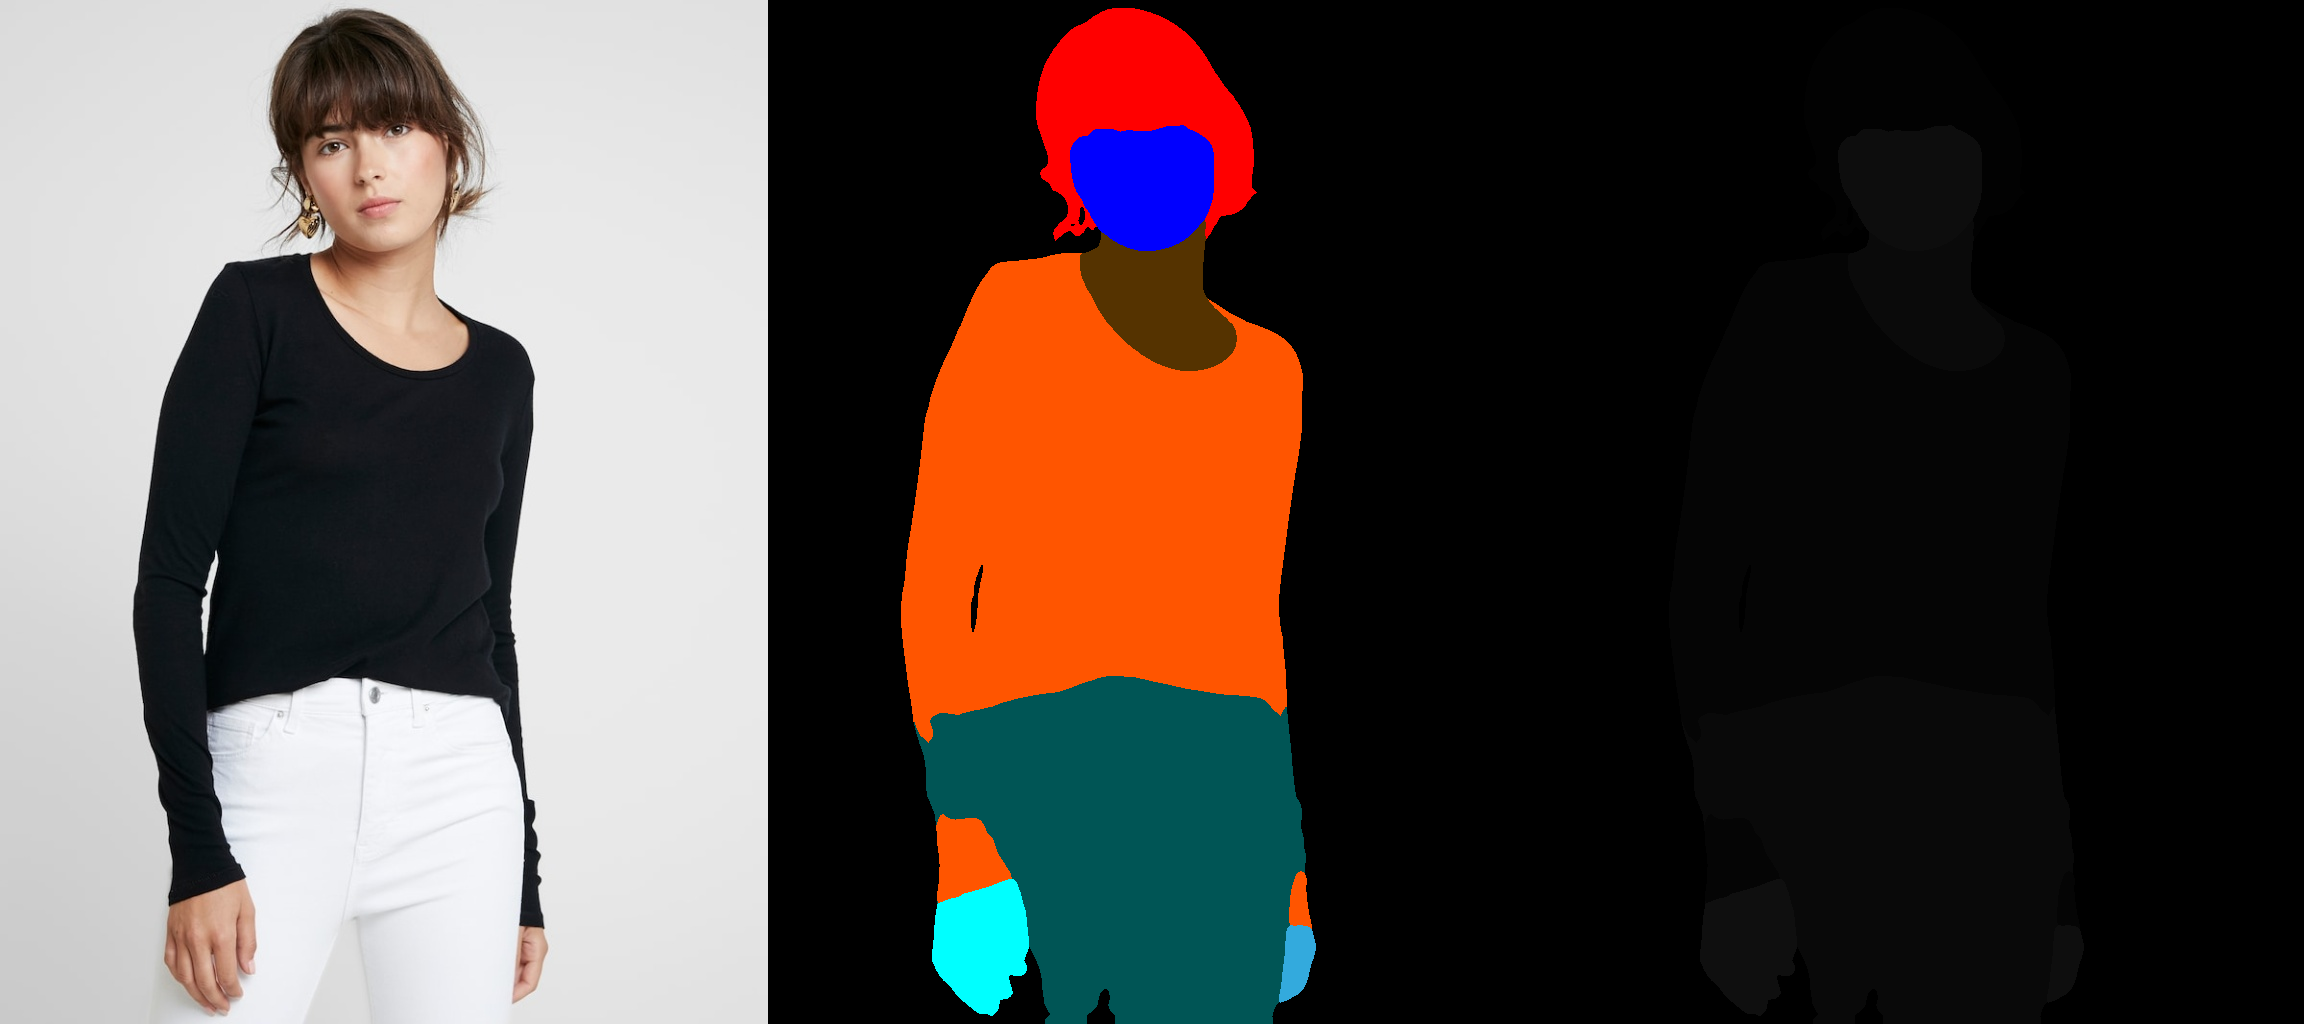

In [16]:
## 查看推理结果

from PIL import Image
import cv2
import os
import numpy as np

images = [os.path.join(f"./CIHP_PGN/datasets/images", x) for x in os.listdir(f"./CIHP_PGN/datasets/images")]
inputs = images[:1]
cihp_edge_maps = [os.path.join(f"./CIHP_PGN/datasets/output/cihp_edge_maps", x) for x in os.listdir(f"./CIHP_PGN/datasets/output/cihp_edge_maps")]

cihp_parsing_maps = [os.path.join(f"./CIHP_PGN/datasets/output/cihp_parsing_maps", x) for x in os.listdir(f"./CIHP_PGN/datasets/output/cihp_parsing_maps")]
sample_images = cihp_parsing_maps[:2]
for idx, image_path in enumerate(sample_images):
    if idx == 0: 
        i_image = cv2.imread(inputs[idx])
        i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2RGB)
        res = i_image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if idx == 0:
        res =  np.concatenate([res, image], axis=1)
    else:
        res = np.concatenate([res, image], axis=1)

res = Image.fromarray(res)
res
    
# for idx, image_path in enumerate(sample_images):
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     if idx == 0:
#         res = image
#     else:
#         res = np.concatenate([res, image], axis=1)
# gif_str = image_path.strip(".jpg")
# gif_str = gif_str.strip("./openpose/output/img_path")
# json_str = f'./openpose/output/json_path/{gif_str}_keypoints.json'
# # print(json_str)

# sample_images = output_images[:1]
# for idx, image_path in enumerate(sample_images):
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     res = np.concatenate([res, image], axis=1)




In [7]:
!cp -r ./CIHP_PGN/datasets/output/cihp_parsing_maps/*_vis.png /data/aigc/HR-VITON/data/test_new/image-parse-v3/
!rm -rf ./CIHP_PGN/datasets/output/cihp_parsing_maps/*

import os

img_dir='/data/aigc/HR-VITON/data/test_new/image-parse-v3/'
for filename in os.listdir(img_dir):
    if "_vis" in filename:
        new_filename = filename.replace("_vis", "")
        os.rename(os.path.join(img_dir, filename), os.path.join(img_dir, new_filename))
        print(f'{filename} => {new_filename}')

00006_00_vis.png => 00006_00.png
00008_00_vis.png => 00008_00.png
00013_00_vis.png => 00013_00.png
00017_00_vis.png => 00017_00.png
00034_00_vis.png => 00034_00.png


## DensePose

### 进入DensePose 环境.3

> 切换Conda环境到 detectron2

> https://github.com/facebookresearch/detectron2

> 帮助文档：https://detectron2.readthedocs.io/en/latest/tutorials/getting_started.html?highlight=train_net.py#training-evaluation-in-command-line

In [1]:
!git clone https://github.com/facebookresearch/detectron2
# ./detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 15124, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 15124 (delta 75), reused 97 (delta 55), pack-reused 14979
Receiving objects: 100% (15124/15124), 6.17 MiB | 40.02 MiB/s, done.
Resolving deltas: 100% (10944/10944), done.


In [4]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

!pip install -e detectron2

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 111.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 91.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 36.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 14.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 13.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 687.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Obtaining file:///data/aigc/HR-VITON/package/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 105.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 121.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 111.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 20.2 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=ac5f243becde031bac658d8fa635ce7293041960b9bef7e25f0386952b38952e
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=c0c84dcac5c3e3e8fe1bd2add2b0e360e7bfd4d6fc8603464d1a7655ffd24c74
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=102206 sha256=79ce2ce588fab1025832fc1a698dcd494bd316c2762f42ab5c25265c023acff7
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac9

In [5]:
# !cd detectron2/projects/DensePose
!pip install av>=8.0.3 opencv-python-headless>=4.5.3.56 scipy>=1.5.4

In [12]:
!mkdir ./detectron2/projects/DensePose/image_path
!cp ../data/test/image/000* ./detectron2/projects/DensePose/image_path

mkdir: cannot create directory ‘./detectron2/projects/DensePose/image_path’: File exists


## 这里需要修改代码
./densepose/vis/densepose_results.py:320
```
 alpha=0.7 to 1
 inplace=True to False
```

./densepose/vis/base.py:38
```
image_target_bgr = image_bgr * 0
to 
image_target_bgr = image_bgr
image_target_bgr *= 0
```

apply_net.py:286:287
```
out_fname = './image-densepose/' + image_fpath.split('/')[-1]
out_dir = './image-densepose'
```



In [24]:
### test/image-densepose
!cd detectron2/projects/DensePose && python apply_net.py  show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
image_path dp_segm -v 

[06/29 03:30:15 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[06/29 03:30:15 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[06/29 03:30:16 apply_net]: Loading data from image_path
/data/miniconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[06/29 03:30:18 apply_net]: Processing image_path/00006_00.jpg
[06/29 03:30:18 apply_net]: Output saved to ./image-densepose/00006_00.jpg
[06/29 03:30:19 apply_net]: Processing image_path/00008_00.jpg
[06/29 03:30:19 apply_net]: Output saved to ./image-densepose/00008_00.jpg
[06/29 03:30:19 apply_net]: Processing image_path/00013_00.jpg
[06/29 03:30:19 apply_net]: Output saved to ./im

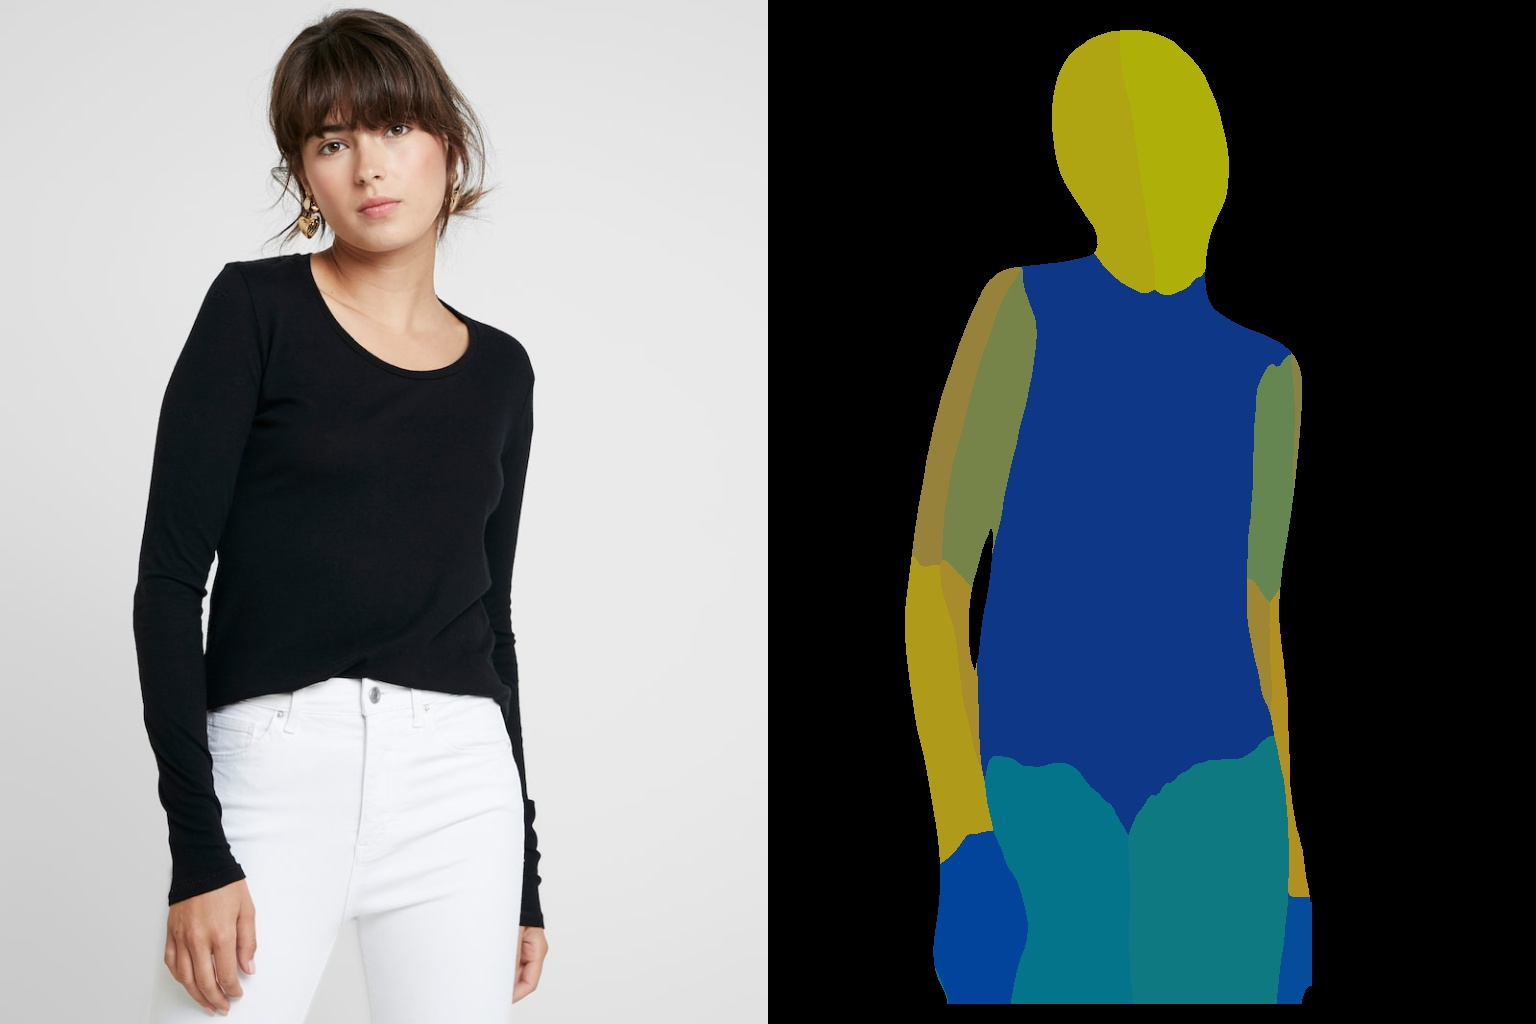

In [27]:
## 查看推理结果

from PIL import Image
import cv2
import os
import numpy as np

images = [os.path.join(f"./detectron2/projects/DensePose/image_path", x) for x in os.listdir(f"./detectron2/projects/DensePose/image_path")]
inputs = images[:1]

output = [os.path.join(f"./detectron2/projects/DensePose/image-densepose", x) for x in os.listdir(f"./detectron2/projects/DensePose/image-densepose")]
sample_images = output[:1]
for idx, image_path in enumerate(sample_images):
    if idx == 0: 
        i_image = cv2.imread(inputs[idx])
        i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2RGB)
        res = i_image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if idx == 0:
        res =  np.concatenate([res, image], axis=1)
    else:
        res = np.concatenate([res, image], axis=1)

res = Image.fromarray(res)
res

In [9]:
!cp -r ./detectron2/projects/DensePose/image-densepose/* /data/aigc/HR-VITON/data/test_new/image-densepose
!rm -rf ./detectron2/projects/DensePose/image-densepose

## Cloth Mask
> 转到：http://127.0.0.0:8888/notebooks/Cloth%20Mask.ipynb

In [1]:
!pip install carvekit_colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 30.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 13.4 MB/s eta 0:00:00


In [73]:
import shutil
from flask import request
from IPython.display import display, HTML
html_form = '''
<form enctype="multipart/form-data" action="/uploadimg" method="post">
  <input type="file" name="image" accept="image/*">
  <input type="submit" value="上传">
</form>
'''

display(HTML(html_form))


@app.route('/uploadimg', methods=['POST'])
def uploadimg():
    if 'image' in request.files:
        image_file = request.files['image']
        # 将图片保存到指定目录
        image_file.save('/tmp/imgs/' + image_file.filename)
        return '图片上传成功！'
    else:
        return '未选择图片！'
